# Assignment 01

In [85]:
import networkx as nx
import numpy as np
import pandas as pd
import requests
import random
import zipfile
import os
import io
import matplotlib.pyplot as plt
from scipy.io import mmread
from bs4 import BeautifulSoup
random.seed(456)

## Question 3

### Choice: Katz centrality

**(a)** Write a function to compute a single node's centrality in a network

In [2]:
def compute_katz_centrality(G, n, alpha=0.001, beta=1.0, max_iter=1000, tol=1e-6):
    """
    Compute the Katz centrality for a single node n in graph G.
    
    Parameters:
    - G: NetworkX graph (Graph or DiGraph)
    - n: node in G
    - alpha: attenuation factor (float)
    - beta: initial centrality value (float)
    - max_iter: maximum number of iterations (int)
    - tol: tolerance for convergence (float)
    
    Returns:
    - centrality value for node n (float)
    """
    try:
        A = nx.adjacency_matrix(G)
    except Exception as e:
        raise ValueError("Failed to compute adjacency matrix.") from e
    
    # Alpha should be less the reciprocal of the largest eigenvalue
    try:
        eigenvalues = np.linalg.eigvals(A.toarray())
        max_eigenvalue = max(abs(eigenvalues))
        if max_eigenvalue == 0:
            raise ValueError("Adjacency matrix has zero eigenvalue. Cannot compute Katz centrality.")
    except Exception as e:
        raise ValueError("Failed to compute eigenvalues of the adjacency matrix") from e
    
    if alpha >= 1 / max_eigenvalue:
        raise ValueError(f"Alpha must be less than {1 / max_eigenvalue:.4f}.")
    
    # Initialize centrality vector
    n_nodes = G.number_of_nodes()
    x = np.ones(n_nodes)
    ones = np.ones(n_nodes)
    node_list = list(G.nodes())
    node_index = {node: idx for idx, node in enumerate(node_list)}
    
    for i in range(max_iter):
        x_old = x.copy()
        x = alpha * A.dot(x) + beta * ones
        # Check for convergence
        if np.linalg.norm(x - x_old, ord=1) < tol:
            break
    else:
        raise ValueError("Katz centrality failed to converge")
    
    idx = node_index[n]
    return x[idx]


In [3]:
G_er=nx.erdos_renyi_graph(500,0.5)
G_ba=nx.barabasi_albert_graph(500,3)
G_ws=nx.watts_strogatz_graph(500,10,0.5)
G_lb=nx.random_lobster(500,0.3,0.4)

In [4]:
compute_katz_centrality(G_ba,3)

1.054586458848552

**(b)** Augment with error handling:

i. A node that is not in the graph

ii. A graph that is not a networkx object

iii. A graph with no connectivity (or not enough connectivity to produce a valid
centrality result)

iv. Any situation that might produce numerical difficulties (e.g. dividing by
zero) for your chosen centrality measure

In [48]:
def compute_katz_centrality(G, n, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6):
    """
    Compute the Katz centrality for a single node n in graph G.
    
    Parameters:
    - G: NetworkX graph (Graph or DiGraph)
    - n: node in G
    - alpha: attenuation factor (float)
    - beta: initial centrality value (float)
    - max_iter: maximum number of iterations (int)
    - tol: tolerance for convergence (float)
    
    Returns:
    - centrality value for node n (float)
    """
    # Error handling:
    if not isinstance(G, (nx.Graph, nx.DiGraph)):
        raise TypeError("G must be a NetworkX graph.")
    if n not in G:
        raise ValueError(f"Node {n} is not in the graph.")
    if G.number_of_nodes() == 0:
        raise ValueError("Graph has no nodes.")
    if G.number_of_edges() == 0:
        print("Warning: Graph has no edges. Adjacency matrix is singular.")
    
    try:
        A = nx.adjacency_matrix(G)
    except Exception as e:
        raise ValueError("Failed to compute adjacency matrix.") from e
    
    # Alpha should be less the reciprocal of the largest eigenvalue
    try:
        eigenvalues = np.linalg.eigvals(A.toarray())
        max_eigenvalue = max(abs(eigenvalues))
        if max_eigenvalue == 0:
            raise ValueError("Adjacency matrix has zero eigenvalue. Cannot compute Katz centrality.")
    except Exception as e:
        raise ValueError("Failed to compute eigenvalues of the adjacency matrix") from e
    
    if alpha >= 1 / max_eigenvalue:
        raise ValueError(f"Alpha must be less than {1 / max_eigenvalue:.4f}.")
    
    # Initialize centrality vector
    n_nodes = G.number_of_nodes()
    x = np.ones(n_nodes)
    ones = np.ones(n_nodes)
    node_list = list(G.nodes())
    node_index = {node: idx for idx, node in enumerate(node_list)}
    
    for i in range(max_iter):
        x_old = x.copy()
        x = alpha * A.dot(x) + beta * ones
        # Check for convergence
        if np.linalg.norm(x - x_old, ord=1) < tol:
            break
    else:
        raise ValueError("Katz centrality failed to converge")    
    idx = node_index[n]
    return x[idx]


**(c)** Compare with networkx function

In [45]:
graphs = {}

G1 = nx.path_graph(5)
graphs['Path Graph'] = G1

# Disconnected
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4, 5])
G2.add_edges_from([(1, 2), (3, 4)])
graphs['Disconnected Graph'] = G2

# Empty
G3 = nx.Graph()
graphs['Empty Graph'] = G3

# Single node
G4 = nx.Graph()
G4.add_node(1)
graphs['Single Node Graph'] = G4

# Complete
G5 = nx.complete_graph(5)
graphs['Complete Graph'] = G5

# self-loop
G6 = nx.Graph()
G6.add_edge(1, 1)
G6.add_edge(1, 2)
G6.add_edge(2, 3)
graphs['Graph with Self-loop'] = G6


In [46]:
for name, G in graphs.items():
    print(f"Testing {name}")
    nodes = G.nodes()
    try:
        nx_katz = nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6, normalized=False)
    except Exception as e:
        nx_katz = {}
        print(f"NetworkX Katz centrality failed: {e}")
    
    for n in nodes:
        try:
            our_result = compute_katz_centrality(G, n)
        except Exception as e:
            our_result = str(e)
        nx_result = nx_katz.get(n, "Exception")
        print(f"Node {n}: Our result = {our_result}, NetworkX result = {nx_result}")
    print()

Testing Path Graph
Node 0: Our result = 1.123711321, NetworkX result = 1.12371124
Node 1: Our result = 1.237113372, NetworkX result = 1.23711321
Node 2: Our result = 1.247422642, NetworkX result = 1.24742248
Node 3: Our result = 1.237113372, NetworkX result = 1.23711321
Node 4: Our result = 1.123711321, NetworkX result = 1.12371124

Testing Disconnected Graph
Node 1: Our result = 1.1111111, NetworkX result = 1.111111
Node 2: Our result = 1.1111111, NetworkX result = 1.111111
Node 3: Our result = 1.1111111, NetworkX result = 1.111111
Node 4: Our result = 1.1111111, NetworkX result = 1.111111
Node 5: Our result = 1.0, NetworkX result = 1.0

Testing Empty Graph

Testing Single Node Graph
Node 1: Our result = Failed to compute eigenvalues of the adjacency matrix, NetworkX result = 1.0

Testing Complete Graph
Node 0: Our result = 1.6666665521342054, NetworkX result = 1.6666663803355135
Node 1: Our result = 1.6666665521342054, NetworkX result = 1.6666663803355135
Node 2: Our result = 1.66666

**(d)** Write **tests** function

In [60]:
def test_centrality_function(centrality_func,networkx_centrality_func):
    graphs = {}
    
    # connected
    G1 = nx.path_graph(5)
    graphs['Path Graph'] = G1
    
    # diconnected
    G2 = nx.Graph()
    G2.add_nodes_from([1, 2, 3, 4, 5])
    G2.add_edges_from([(1, 2), (3, 4)])
    graphs['Disconnected Graph'] = G2
    
    # empty
    G3 = nx.Graph()
    graphs['Empty Graph'] = G3
    
    # single node
    G4 = nx.Graph()
    G4.add_node(1)
    graphs['Single Node Graph'] = G4
    
    # complete
    G5 = nx.complete_graph(5)
    graphs['Complete Graph'] = G5
    
    # self-loop
    G6 = nx.Graph()
    G6.add_edge(1, 1)
    G6.add_edge(1, 2)
    G6.add_edge(2, 3)
    graphs['Graph with Self-loop'] = G6
    
    for name, G in graphs.items():
        print(f"Testing {name}")
        nodes = G.nodes()
        if len(nodes) ==0:
            print(f"This is an empty graph")
            print()
        else:
            try:
                nx_katz = networkx_centrality_func(
                    G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6, normalized=False
                )
            except Exception as e:
                nx_katz = {}
                print(f"NetworkX Katz centrality failed: {e}")
            
            for n in nodes:
                try:
                    our_result = centrality_func(
                        G, n, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-6
                    )
                except Exception as e:
                    our_result = str(e)
                nx_result = nx_katz.get(n, "Exception")
                print(f"Node {n}: Our result = {our_result}, NetworkX result = {nx_result}")
            print()


In [61]:
test_centrality_function(compute_katz_centrality,nx.katz_centrality)

Testing Path Graph
Node 0: Our result = 1.123711321, NetworkX result = 1.12371124
Node 1: Our result = 1.237113372, NetworkX result = 1.23711321
Node 2: Our result = 1.247422642, NetworkX result = 1.24742248
Node 3: Our result = 1.237113372, NetworkX result = 1.23711321
Node 4: Our result = 1.123711321, NetworkX result = 1.12371124

Testing Disconnected Graph
Node 1: Our result = 1.1111111, NetworkX result = 1.111111
Node 2: Our result = 1.1111111, NetworkX result = 1.111111
Node 3: Our result = 1.1111111, NetworkX result = 1.111111
Node 4: Our result = 1.1111111, NetworkX result = 1.111111
Node 5: Our result = 1.0, NetworkX result = 1.0

Testing Empty Graph
This is an empty graph

Testing Single Node Graph
Node 1: Our result = Failed to compute eigenvalues of the adjacency matrix, NetworkX result = 1.0

Testing Complete Graph
Node 0: Our result = 1.6666665521342054, NetworkX result = 1.6666663803355135
Node 1: Our result = 1.6666665521342054, NetworkX result = 1.6666663803355135
Node 

## Question 4

### Construct a DAG (directed acyclic graph) of the curriculum

In [75]:
catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
catalog_html = catalog_res.text
soup = BeautifulSoup(catalog_html)
soup_alpha_div = soup.find('div', id="atozindex")
first_ul = soup_alpha_div.find('ul')
first_bullet = first_ul.find('li')
print('\n Finally, we can get the link and its href (the partial URL that points to the accounting courses):')
print(first_bullet.a.get('href'))


 Finally, we can get the link and its href (the partial URL that points to the accounting courses):
/course-descriptions/acct/


In [76]:
department_hrefs = []
for ul in soup_alpha_div.find_all('ul'):
    for li in ul.find_all('li'):
        department_hrefs.append(li.a.get('href'))

In [86]:
my_href = random.choice(department_hrefs)

my_full_url = 'https://catalog.northeastern.edu' + my_href
print(my_full_url)
dept_html = requests.get(my_full_url).text

https://catalog.northeastern.edu/course-descriptions/pols/


In [87]:
def get_course_titles_and_descriptions(dept_html):
    descriptions=[] 
    course_list=[]
    soup = BeautifulSoup(dept_html)
    site_title_dept = soup.find('div', id="site-title")
    courses=soup.find('div',id='textcontainer')
    course_elements = soup.select('#textcontainer > div > div > p.courseblocktitle.noindent > strong')
    description_elements = soup.select('#textcontainer > div > div > p.cb_desc')
    for course, description in zip(course_elements, description_elements):
        course_list.append(course.get_text(strip=True))
        descriptions.append(description.get_text(strip=True))
    courses_df = pd.DataFrame({
        'course': course_list,
        'description': descriptions
    })
    return site_title_dept,courses_df

In [88]:
site_title_dept, courses_df=get_course_titles_and_descriptions(dept_html)
courses_df.tail()

,course,description
106,POLS 9000. PhD Candidacy Achieved. (0 Hours),Indicates successful completion of the doctora...
107,POLS 9986. Research. (0 Hours),Offers an opportunity to conduct full-time res...
108,POLS 9990. Dissertation Term 1. (0 Hours),Offers dissertation supervision by individual ...
109,POLS 9991. Dissertation Term 2. (0 Hours),Offers dissertation supervision by members of ...
110,POLS 9996. Dissertation Continuation. (0 Hours),Offers continued dissertation supervision by i...


**(a)** Scrape prerequisite of each course

**(b)**

## Question 5

Choice: download the data of Minnesota road network

In [68]:
url = "https://nrvis.com/download/data/road/road-minnesota.zip"
response = requests.get(url)
response.raise_for_status() 
with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    mtx_filename = next((f for f in thezip.namelist() if f.endswith('.mtx')), None)
    if mtx_filename is None:
        raise FileNotFoundError("No .mtx file found in the ZIP archive.")
    with thezip.open(mtx_filename) as mtx_file:
        adjacency_matrix = mmread(mtx_file)
G = nx.from_scipy_sparse_array(adjacency_matrix)

**(b)** Compare with randomized network

In [69]:
# degree-preserving randomization
degree_sequence = [d for n, d in G.degree()]
G_random = nx.configuration_model(degree_sequence)
G_random = nx.Graph(G_random)
G_random.remove_edges_from(nx.selfloop_edges(G_random))

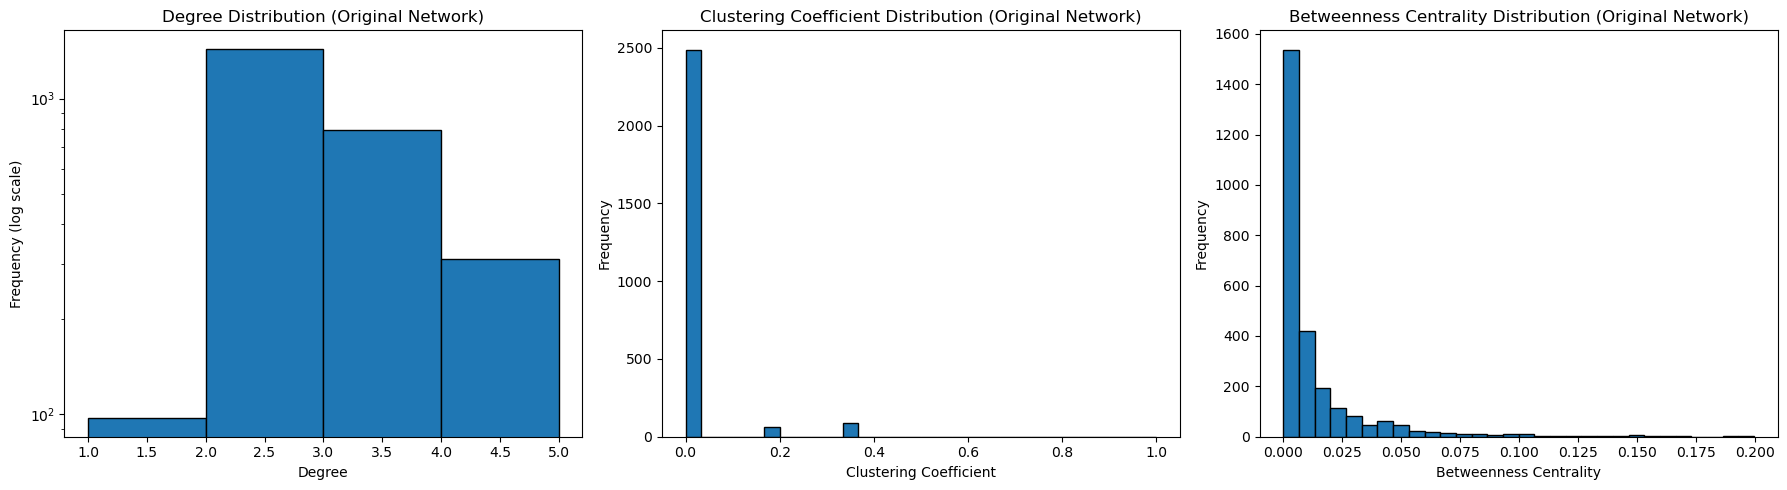

In [70]:
# Original network:
degree_sequence = [d for n, d in G.degree()]
clustering_coeffs = list(nx.clustering(G).values())
betweenness_centrality = list(nx.betweenness_centrality(G).values())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(degree_sequence, bins=range(1, max(degree_sequence)+1), edgecolor='black', log=True)
axes[0].set_title('Degree Distribution (Original Network)')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency (log scale)')
axes[1].hist(clustering_coeffs, bins=30, edgecolor='black')
axes[1].set_title('Clustering Coefficient Distribution (Original Network)')
axes[1].set_xlabel('Clustering Coefficient')
axes[1].set_ylabel('Frequency')
axes[2].hist(betweenness_centrality, bins=30, edgecolor='black')
axes[2].set_title('Betweenness Centrality Distribution (Original Network)')
axes[2].set_xlabel('Betweenness Centrality')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

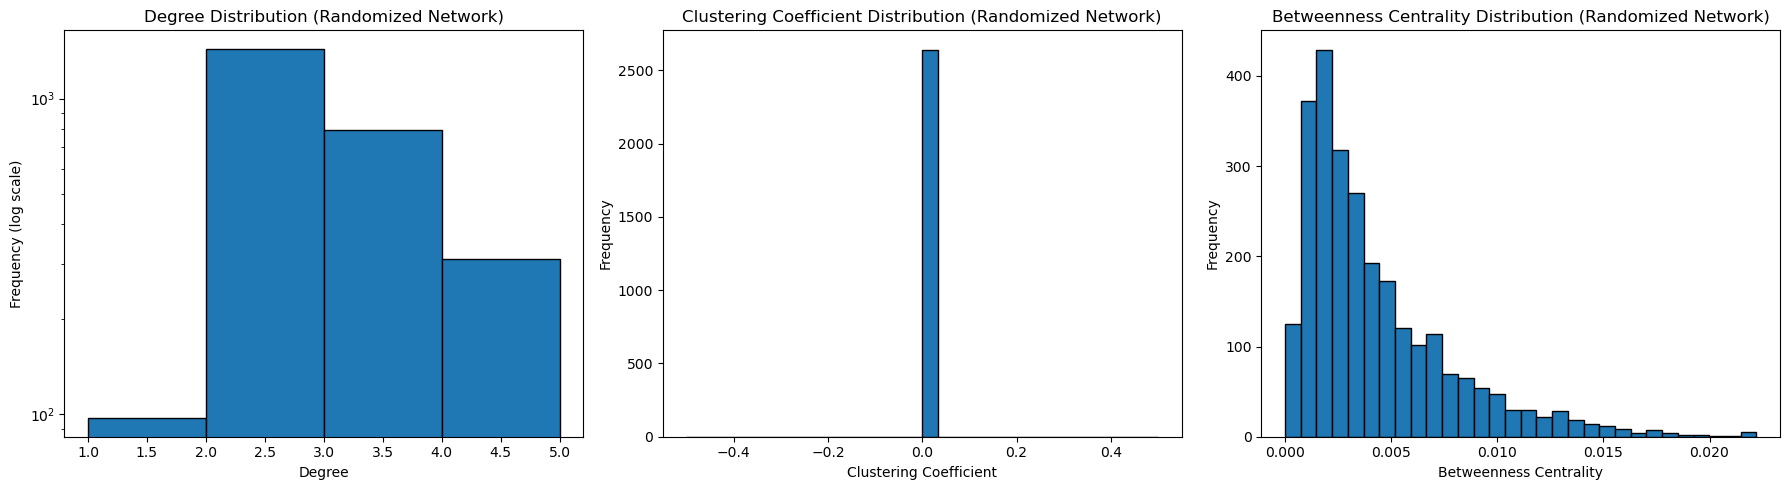

In [71]:
# Configuration model
degree_sequence_random = [d for n, d in G_random.degree()]
clustering_coeffs_random = list(nx.clustering(G_random).values())
betweenness_centrality_random = list(nx.betweenness_centrality(G_random).values())


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(degree_sequence_random, bins=range(1, max(degree_sequence_random)+1), edgecolor='black', log=True)
axes[0].set_title('Degree Distribution (Randomized Network)')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency (log scale)')
axes[1].hist(clustering_coeffs_random, bins=30, edgecolor='black')
axes[1].set_title('Clustering Coefficient Distribution (Randomized Network)')
axes[1].set_xlabel('Clustering Coefficient')
axes[1].set_ylabel('Frequency')
axes[2].hist(betweenness_centrality_random, bins=30, edgecolor='black')
axes[2].set_title('Betweenness Centrality Distribution (Randomized Network)')
axes[2].set_xlabel('Betweenness Centrality')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()